# VecNet Set-up

## Imports

In [1]:
import importlib
from matplotlib.pyplot import figure
from AIBind.import_modules import *
from AIBind import AIBind
from scipy import stats
from scipy.signal import find_peaks
import seaborn as sns
from matplotlib.patches import Patch
import pubchempy as pcp

Traceback (most recent call last):
  File "/miniconda/lib/python3.6/site-packages/rdkit/Chem/PandasTools.py", line 130, in <module>
    if 'display.width' in pd.core.config._registered_options:
AttributeError: module 'pandas.core' has no attribute 'config'


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
importlib.reload(AIBind)

<module 'AIBind.AIBind' from '/home/sars-busters-consolidated/GitCode/AIBind/AIBind.py'>

In [3]:
def get_all_indices(mylist, myval):
    
    all_indices = []
    
    for i in range(len(mylist)):
        if mylist[i] == myval:
            all_indices.append(i)
            
    return all_indices

In [4]:
def get_mode_x_from_sns(sns_plot, plot_no):
    
    data_x, data_y = sns_plot.lines[2*plot_no].get_data()
    data_x = list(data_x)
    data_y = list(data_y)
    max_index = data_y.index(max(data_y))
    
    return data_x[max_index]

In [5]:
def moving_avg(numbers, window_size=10): # even window size
    
    ma_list = []
    
    # for j in range(window_size-1 ,len(numbers)-window_size):
    for j in range(len(numbers)):
        # ma_list.append(np.mean(numbers[j:j+window_size]))
        try:
            ma_list.append(np.mean(numbers[int(j-window_size/2):int(j+window_size/2)]))
        except:
            ma_list.append(numbers[j])
        
    #ma_list = ma_list + numbers[len(numbers)-window_size:len(numbers)]
    
    return ma_list

In [6]:
def replacer(s, newstring, index, nofail=False):
    # raise an error if index is outside of the string
    if not nofail and index not in range(len(s)):
        raise ValueError("index outside given string")

    # if not erroring, but the index is still not in the correct range..
    if index < 0:  # add it to the beginning
        return newstring + s
    if index > len(s):  # add it to the end
        return s + newstring

    # insert the new string between "slices" of the original
    return s[index : index + len(newstring)], s[:index] + newstring + s[index + len(newstring):]

In [7]:
## Trivial features function for ligands 

from rdkit.Chem import Descriptors
from collections import defaultdict
from rdkit.Chem import FindMolChiralCenters

boron = 5
carbon = 6
nitrogen = 7 
oxygen = 8 
fluorine = 9 
phosphorus = 15
sulfur = 16
chlorine = 17
bromine = 35 
iodine = 53 

elements = [boron, carbon, nitrogen, oxygen, fluorine, phosphorus, sulfur, \
           chlorine, bromine, iodine]

def calculate_simple_fingerprints(x):
    """compute trivial fingerprints based on RDKit mol object"""
    
    atom_count = defaultdict(int)
    for element in elements:
        atom_count[element] = 0
    for atom in x.GetAtoms():
        atom_count[atom.GetAtomicNum()]+=1

    num_atoms = x.GetNumAtoms()
    count_boron = atom_count[boron]
    count_carbon = atom_count[carbon]
    count_nitrogen = atom_count[nitrogen] 
    count_oxygen = atom_count[oxygen]
    count_fluorine = atom_count[fluorine] 
    count_phosphorus = atom_count[phosphorus]
    count_sulfur = atom_count[sulfur]
    count_chlorine = atom_count[chlorine]
    count_bromine = atom_count[bromine]
    count_iodine = atom_count[iodine]
    heavy_count = Descriptors.HeavyAtomCount(x)
    mw = Descriptors.MolWt(x)
    hacc = Descriptors.NumHAcceptors(x)
    hdon = Descriptors.NumHDonors(x)
    logp = Descriptors.MolLogP(x)
    numrings = Descriptors.NumAromaticRings(x) + Descriptors.NumSaturatedRings(x) + \
    Descriptors.NumAliphaticRings(x)
    num_chiral = len(FindMolChiralCenters(x))
    
    return [num_atoms,
    count_boron,
    count_carbon,
    count_nitrogen,
    count_oxygen,
    count_fluorine, 
    count_phosphorus,
    count_sulfur,
    count_chlorine,
    count_bromine,
    count_iodine,
    heavy_count,
    mw,
    hacc,
    hdon,
    logp,
    numrings,
    num_chiral]

## GPU Settings

In [9]:
str(subprocess.check_output('nvidia-smi', shell = True)).split('\\n')

["b'Tue Mar 29 04:21:39 2022       ",
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   60C    P0    30W /  70W |      0MiB / 15079MiB |      0%      Default |',
 '+-------------------------------+----------------------+----------------------+',
 '                                                                               ',
 '+-----------------------------------------------------------------------------+',
 '| Processes:                        

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## VecNet Object Definition

In [9]:
# Read In drugs and targets dataframes to pass to AIBind after changing column names 
with open('/data/sars-busters/Mol2Vec/chemicals_01_w_embed.pkl', 'rb') as file: 
    drugs = pkl.load(file)
    
with open('/data/sars-busters/Mol2Vec/amino_01_w_embed.pkl', 'rb') as file: 
    targets = pkl.load(file)

# Ensure correct column names    
drugs = drugs.rename(columns = {'Label' : 'InChiKey'})
targets = targets.rename(columns = {'Label' : 'target_aa_code'})

In [10]:
targets_test = []
targets_validation = []
edges_test = []
edges_validation = []
train_sets = []

for run_number in tqdm(range(5)):
    
    targets_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_nodes_' + str(run_number) + '.csv'))
    edges_test.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/test_unseen_edges_' + str(run_number) + '.csv'))    
    targets_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_nodes_' + str(run_number) + '.csv'))    
    edges_validation.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/validation_unseen_edges_' + str(run_number) + '.csv'))    
    train_sets.append(pd.read_csv('/data/sars-busters-consolidated/GitData/VecNet_Unseen_Nodes/train_' + str(run_number) + '.csv'))    

  0%|          | 0/5 [00:00<?, ?it/s]

In [11]:
vecnet_object = AIBind.AIBind(interactions_location = '/data/sars-busters-consolidated/GitData/interactions/Network_Derived_Negatives.csv',
                              interactions = None,
                              interaction_y_name = 'Y',

                              absolute_negatives_location = None,
                              absolute_negatives = None,

                              drugs_location = None,
                              drugs_dataframe = drugs,
                              drug_inchi_name = 'InChiKey',
                              drug_smile_name = 'SMILE',

                              targets_location = None,
                              targets_dataframe = targets, 
                              target_seq_name = 'target_aa_code',

                              mol2vec_location = None,
                              mol2vec_model = None,

                              protvec_location = None, 
                              protvec_model = None,

                              nodes_test = targets_test, 
                              nodes_validation = targets_validation, 

                              edges_test = edges_test, 
                              edges_validation = edges_validation, 

                              model_out_dir = '/data/sars-busters-consolidated/VecNet/KF-Final/',

                              debug = False)

## Updating ProtVec Model with unknown vector for 'xxx'

In [12]:
with open('/data/sars-busters-consolidated/GitData/VecNet_unseen_nodes_1.pickle', 'rb') as file:
    vecnet_object = pkl.load(file) 

In [45]:
protvec_model = pd.read_csv('/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams.csv', delimiter = '\t')

In [16]:
protvec_model_except_unk = protvec_model[0:9048]
protvec_vectors = protvec_model_except_unk.copy()
protvec_vectors_only = protvec_vectors.drop(columns=['words'])
protvec_vectors_only_matrix = np.matrix(protvec_vectors_only)

In [17]:
## Observation: <ukn> vector is the avergae of all the other vectors ##
protvec_vectors_only_matrix.mean(axis=0)

matrix([[-0.0365621 ,  0.01508602, -0.04216729, -0.07919889, -0.00188331,
         -0.00834733, -0.00675872, -0.0267377 , -0.06309197,  0.06844316,
          0.00526279, -0.03360382, -0.00455384,  0.00180461, -0.02379146,
          0.01074558,  0.0375896 , -0.03366269, -0.02490498, -0.02314171,
         -0.00362042, -0.03179618, -0.06170251,  0.04581856,  0.00446035,
         -0.02557794, -0.04885125, -0.00101591,  0.02928509,  0.00037206,
         -0.01429877, -0.04299931,  0.02940232, -0.01815216,  0.06691434,
          0.02195783, -0.0448909 ,  0.01814325, -0.00868572, -0.01891076,
          0.00249299,  0.00420123,  0.03424111, -0.0268326 , -0.00254612,
          0.00482937, -0.05335729, -0.00447396, -0.01866141,  0.03423755,
         -0.02695097, -0.01403968,  0.00325751, -0.05769703,  0.03716393,
         -0.05929572,  0.00092899, -0.01298988, -0.01539513, -0.02405316,
         -0.00515105,  0.07768848,  0.00226491, -0.03004062,  0.07451231,
         -0.0188233 , -0.03460864,  0.

In [19]:
unknown_vector = protvec_model.loc[[9047]]
unknown_vector['words'] = 'xxx'
unknown_vector

,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
9047,xxx,-0.036558,0.015085,-0.042163,-0.07919,-0.001883,-0.008346,-0.006758,-0.026735,-0.063085,...,0.008905,0.028574,-0.055239,-0.014421,0.034931,-0.008742,-0.058464,-0.051556,-0.040894,0.093684


In [20]:
protvec_model = protvec_model.append(unknown_vector)

In [21]:
protvec_model

,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
0,AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
1,ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
2,LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
3,LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
4,AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9044,XGN,0.012529,0.100273,-0.084018,-0.068436,-0.004238,-0.016091,-0.030392,0.065851,-0.028816,...,0.050221,0.013751,0.008207,0.128722,0.051683,-0.084542,-0.041187,0.070509,-0.123749,0.064368
9045,XWY,-0.078238,0.026070,-0.078415,-0.124451,-0.081429,-0.034911,-0.285715,-0.158854,-0.294208,...,0.027498,0.164893,-0.264212,0.072932,0.135573,0.073504,-0.136748,0.080023,-0.241494,0.131080
9046,XTD,0.090840,0.045846,-0.023550,-0.090981,-0.103220,0.041702,-0.113839,0.019155,-0.028805,...,0.088192,0.182952,-0.223073,-0.007807,-0.066830,-0.133865,-0.422109,0.116075,0.039210,0.062399
9047,<unk>,-0.036558,0.015085,-0.042163,-0.079190,-0.001883,-0.008346,-0.006758,-0.026735,-0.063085,...,0.008905,0.028574,-0.055239,-0.014421,0.034931,-0.008742,-0.058464,-0.051556,-0.040894,0.093684


In [22]:
protvec_model.to_csv('/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams_unknown_trigram.csv', index=False)

In [13]:
## Overwriting the VecNet ProtVec model with the <unk> vector for 'xxx'

vecnet_object.mol2vec_location = '/data/sars-busters/Mol2Vec/model_300dim.pkl',
vecnet_object.protvec_location = '/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams_unknown_trigram.csv',

vecnet_object.protvec_model = pd.read_csv('/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams_unknown_trigram.csv')
vecnet_object.mol2vec_model = word2vec.Word2Vec.load('/data/sars-busters/Mol2Vec/model_300dim.pkl')

In [24]:
pd.read_csv('/home/sars-busters/Mol2Vec/Results/protVec_100d_3grams_unknown_trigram.csv')

,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
0,AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
1,ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
2,LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
3,LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
4,AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9044,XGN,0.012529,0.100273,-0.084018,-0.068436,-0.004238,-0.016091,-0.030392,0.065851,-0.028816,...,0.050221,0.013751,0.008207,0.128722,0.051683,-0.084542,-0.041187,0.070509,-0.123749,0.064368
9045,XWY,-0.078238,0.026070,-0.078415,-0.124451,-0.081429,-0.034911,-0.285715,-0.158854,-0.294208,...,0.027498,0.164893,-0.264212,0.072932,0.135573,0.073504,-0.136748,0.080023,-0.241494,0.131080
9046,XTD,0.090840,0.045846,-0.023550,-0.090981,-0.103220,0.041702,-0.113839,0.019155,-0.028805,...,0.088192,0.182952,-0.223073,-0.007807,-0.066830,-0.133865,-0.422109,0.116075,0.039210,0.062399
9047,<unk>,-0.036558,0.015085,-0.042163,-0.079190,-0.001883,-0.008346,-0.006758,-0.026735,-0.063085,...,0.008905,0.028574,-0.055239,-0.014421,0.034931,-0.008742,-0.058464,-0.051556,-0.040894,0.093684


In [13]:
vecnet_object.protvec_model

,words,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100
0,AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,...,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
1,ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,...,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
2,LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,...,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
3,LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,...,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
4,AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,...,0.154597,-0.050440,0.054866,0.066185,0.017498,0.001773,-0.083944,-0.003867,-0.106367,0.070706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9044,XGN,0.012529,0.100273,-0.084018,-0.068436,-0.004238,-0.016091,-0.030392,0.065851,-0.028816,...,0.050221,0.013751,0.008207,0.128722,0.051683,-0.084542,-0.041187,0.070509,-0.123749,0.064368
9045,XWY,-0.078238,0.026070,-0.078415,-0.124451,-0.081429,-0.034911,-0.285715,-0.158854,-0.294208,...,0.027498,0.164893,-0.264212,0.072932,0.135573,0.073504,-0.136748,0.080023,-0.241494,0.131080
9046,XTD,0.090840,0.045846,-0.023550,-0.090981,-0.103220,0.041702,-0.113839,0.019155,-0.028805,...,0.088192,0.182952,-0.223073,-0.007807,-0.066830,-0.133865,-0.422109,0.116075,0.039210,0.062399
9047,<unk>,-0.036558,0.015085,-0.042163,-0.079190,-0.001883,-0.008346,-0.006758,-0.026735,-0.063085,...,0.008905,0.028574,-0.055239,-0.014421,0.034931,-0.008742,-0.058464,-0.051556,-0.040894,0.093684


In [14]:
vecnet_object.get_mol2vec_embeddings()
vecnet_object.get_protvec_embeddings()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Prediction 

In [15]:
sentence = 'QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFGTAHCWLNEEKISDNPPRTCKMCISFDPLIPLLRSLPFKKSDKDLYIRGQFNIICVWVFLFVFYNGVSLCCPVWSAVAQSQLTAISASWVQTILLPSGSPVAGITGTCYHTQLIFLFFVLFCFETKSCSVAQIGGQWRSLSSLQPPPPSFKQFSCLSFPSSWDYRRPPPHPTNFCFCFYFFFFETESRSVAQAGVQWRDLGSLQAPPPGFTPFFCLSPPSSWDYRRLPPRLANFIYF'
replacer(sentence, 'xxx', index=0, nofail=False)

('QSK',
 'xxxTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFGTAHCWLNEEKISDNPPRTCKMCISFDPLIPLLRSLPFKKSDKDLYIRGQFNIICVWVFLFVFYNGVSLCCPVWSAVAQSQLTAISASWVQTILLPSGSPVAGITGTCYHTQLIFLFFVLFCFETKSCSVAQIGGQWRSLSSLQPPPPSFKQFSCLSFPSSWDYRRPPPHPTNFCFCFYFFFFETESRSVAQAGVQWRDLGSLQAPPPGFTPFFCLSPPSSWDYRRLPPRLANFIYF')

In [16]:
top_df = pd.read_csv('/data/sars-busters-consolidated/GitData/top_100_predictions_VecNet_11_15_2021.csv')

In [17]:
top_df

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
0,333533,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.438937,0
1,333618,OWWLUIWOFHMHOQ-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.433777,0
2,333304,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,ZC3H18,0.432257,0
3,1362803,GVEAYVLWDAFXET-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.429415,0
4,1362888,GVEAYVLWDAFXET-XGHATYIMSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.424415,0
...,...,...,...,...,...,...
95,1220573,SEALOBQTUQIVGU-QNIJNHAOSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387469,0
96,2610863,PKVRCIRHQMSYJX-AIFWHQITSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387410,0
97,2151503,LKAJKIOFIWVMDJ-IYRCEVNGSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387335,0
98,2031888,HTIKWNNIPGXLGM-YLINKJIISA-N,LALSICFSEQPIPLQVLLSQEAQLESGMDTEFGASSFFHSPASCHE...,USP54,0.387249,0


# Example - 1 (TRIM59 and Pipecuronium)

In [33]:
protein_seq = top_df['target_aa_code'].tolist()[0]

sample_df = pd.DataFrame()

ligand_inchikey = 'OWWLUIWOFHMHOQ-XGHATYIMSA-N'
ligand_smile = drugs[drugs['InChiKey'] == 'OWWLUIWOFHMHOQ-XGHATYIMSA-N']['SMILE'].tolist()[0]
InChIKey_list = []
target_aa_code_list = []
smile_list = []
replaced_trigram_list = []

for j in tqdm(range(0,len(protein_seq)-3)):

    replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

    sample_df = pd.DataFrame()
    
    InChIKey_list.append(ligand_inchikey)
    target_aa_code_list.append(protein_seq_replaced)
    smile_list.append(ligand_smile)
    replaced_trigram_list.append(replaced_trigram)

sample_df['InChiKey'] = InChIKey_list
sample_df['SMILE'] = smile_list
sample_df['target_aa_code'] = target_aa_code_list
sample_df['replaced_trigram'] = replaced_trigram_list

  0%|          | 0/402 [00:00<?, ?it/s]

In [34]:
sample_df_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [sample_df],
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402


In [35]:
trigrams_in_order = [x for _,x in sorted(zip(sample_df_5fold_average[0]['Averaged Predictions'].tolist(),sample_df_5fold_average[0]['replaced_trigram'].tolist()))]

In [36]:
trigrams_in_order

['NCR',
 'PNC',
 'KCP',
 'LKC',
 'CYS',
 'ICY',
 'CPI',
 'TCP',
 'LMS',
 'MSI',
 'SWP',
 'WPG',
 'CGH',
 'GHC',
 'SVI',
 'VIL',
 'CHI',
 'HIF',
 'RSI',
 'SIT',
 'CSH',
 'PCS',
 'CPN',
 'LTA',
 'TAL',
 'RVL',
 'VLP',
 'ILF',
 'LFF',
 'EEL',
 'ELT',
 'LNV',
 'NVY',
 'ILC',
 'NIL',
 'HWT',
 'WTD',
 'NFA',
 'VNF',
 'CLT',
 'LTI',
 'IFE',
 'SIF',
 'HTF',
 'TFC',
 'IVS',
 'KIV',
 'KSF',
 'SFL',
 'GNF',
 'NFY',
 'ISP',
 'KIS',
 'EMH',
 'MHN',
 'CRS',
 'ALT',
 'LTI',
 'CPE',
 'TCP',
 'FVW',
 'VWK',
 'FEE',
 'NFE',
 'CLL',
 'YCL',
 'LSN',
 'SNS',
 'PIC',
 'KLV',
 'LVC',
 'ILM',
 'LPV',
 'SLP',
 'CDV',
 'LCD',
 'LSV',
 'QSL',
 'SVY',
 'YQS',
 'IWR',
 'YIW',
 'FYL',
 'YLL',
 'FLS',
 'TFL',
 'EVQ',
 'PEV',
 'HGH',
 'HHG',
 'QPL',
 'RQP',
 'CSW',
 'ASL',
 'EAS',
 'LIS',
 'TLI',
 'MSC',
 'SCS',
 'KKK',
 'QKK',
 'LPC',
 'EHY',
 'HYR',
 'KMK',
 'PKM',
 'ELM',
 'LMA',
 'KSH',
 'SHS',
 'GKD',
 'KDE',
 'EIT',
 'SEI',
 'FYI',
 'LIP',
 'VLI',
 'DIV',
 'IVT',
 'KIL',
 'LKI',
 'QSA',
 'SAY',
 'YSI',
 'EYT',


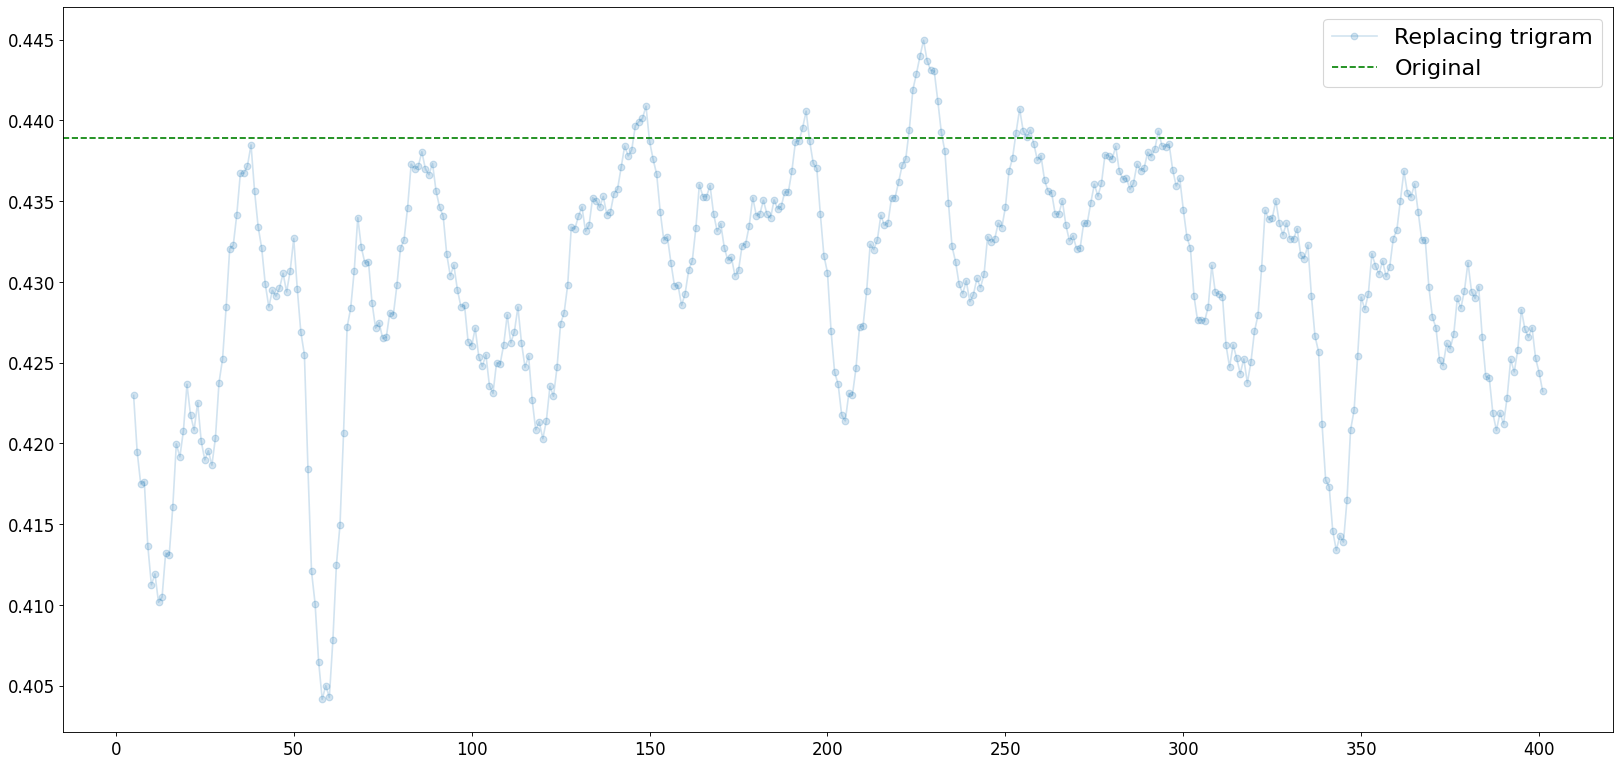

In [23]:
figure(figsize=(25, 12), dpi=80)
plt.plot(range(len(sample_df_5fold_average[0]['replaced_trigram'].tolist())),moving_avg(sample_df_5fold_average[0]['Averaged Predictions'].tolist(), window_size=10), '-o', alpha=0.2, label='Replacing trigram')
plt.axhline(y=top_df['Averaged Predictions'].tolist()[0], color='g', linestyle='--', label='Original')
plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

# Example - 2 (TRIM59 and Pancuronium)

In [24]:
protein_seq = top_df['target_aa_code'].tolist()[3]

sample_df = pd.DataFrame()

ligand_inchikey = 'GVEAYVLWDAFXET-XGHATYIMSA-N'
ligand_smile = drugs[drugs['InChiKey'] == 'GVEAYVLWDAFXET-XGHATYIMSA-N']['SMILE'].tolist()[0]
InChIKey_list = []
target_aa_code_list = []
smile_list = []
replaced_trigram_list = []

for j in tqdm(range(0,len(protein_seq)-3)):

    replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

    sample_df = pd.DataFrame()
    
    InChIKey_list.append(ligand_inchikey)
    target_aa_code_list.append(protein_seq_replaced)
    smile_list.append(ligand_smile)
    replaced_trigram_list.append(replaced_trigram)

sample_df['InChiKey'] = InChIKey_list
sample_df['SMILE'] = smile_list
sample_df['target_aa_code'] = target_aa_code_list
sample_df['replaced_trigram'] = replaced_trigram_list

  0%|          | 0/402 [00:00<?, ?it/s]

In [25]:
sample_df_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [sample_df],
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model


InternalError: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_220_0_5/_1833}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_168__arg_Placeholder_220_0_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[{{node ReadVariableOp_220/_1895}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_229_ReadVariableOp_220", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

In [19]:
trigrams_in_order = [x for _,x in sorted(zip(sample_df_5fold_average[0]['Averaged Predictions'].tolist(),sample_df_5fold_average[0]['replaced_trigram'].tolist()))]

# Example - 3 (TRIM59 and Voclosporin)

In [51]:
top_df[top_df['InChiKey'] == 'BICRTLVBTLFLRD-PTWUADNWSA-N']

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
35,2248193,BICRTLVBTLFLRD-PTWUADNWSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.397443,0
46,2248278,BICRTLVBTLFLRD-PTWUADNWSA-N,KLNVQKSQVYLYTNDRQMESQIMSKHPFIIATKRIKYLGIQLTRDM...,FAR2,0.395617,0
56,2247964,BICRTLVBTLFLRD-PTWUADNWSA-N,QSKTLSLKKKKKKKATFCLYNCQDFGLVCVWVVVVVLSGDTEPRFG...,ZC3H18,0.393129,0


In [52]:
protein_seq = top_df['target_aa_code'].tolist()[35]

sample_df = pd.DataFrame()

ligand_inchikey = 'BICRTLVBTLFLRD-PTWUADNWSA-N'
ligand_smile = drugs[drugs['InChiKey'] == 'BICRTLVBTLFLRD-PTWUADNWSA-N']['SMILE'].tolist()[0]
InChIKey_list = []
target_aa_code_list = []
smile_list = []
replaced_trigram_list = []

for j in tqdm(range(0,len(protein_seq)-3)):

    replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

    sample_df = pd.DataFrame()
    
    InChIKey_list.append(ligand_inchikey)
    target_aa_code_list.append(protein_seq_replaced)
    smile_list.append(ligand_smile)
    replaced_trigram_list.append(replaced_trigram)

sample_df['InChiKey'] = InChIKey_list
sample_df['SMILE'] = smile_list
sample_df['target_aa_code'] = target_aa_code_list
sample_df['replaced_trigram'] = replaced_trigram_list

  0%|          | 0/402 [00:00<?, ?it/s]

In [53]:
sample_df_5fold_average = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = [sample_df],
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402


In [16]:
trigrams_in_order = [x for _,x in sorted(zip(sample_df_5fold_average[0]['Averaged Predictions'].tolist(),sample_df_5fold_average[0]['replaced_trigram'].tolist()))]

/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



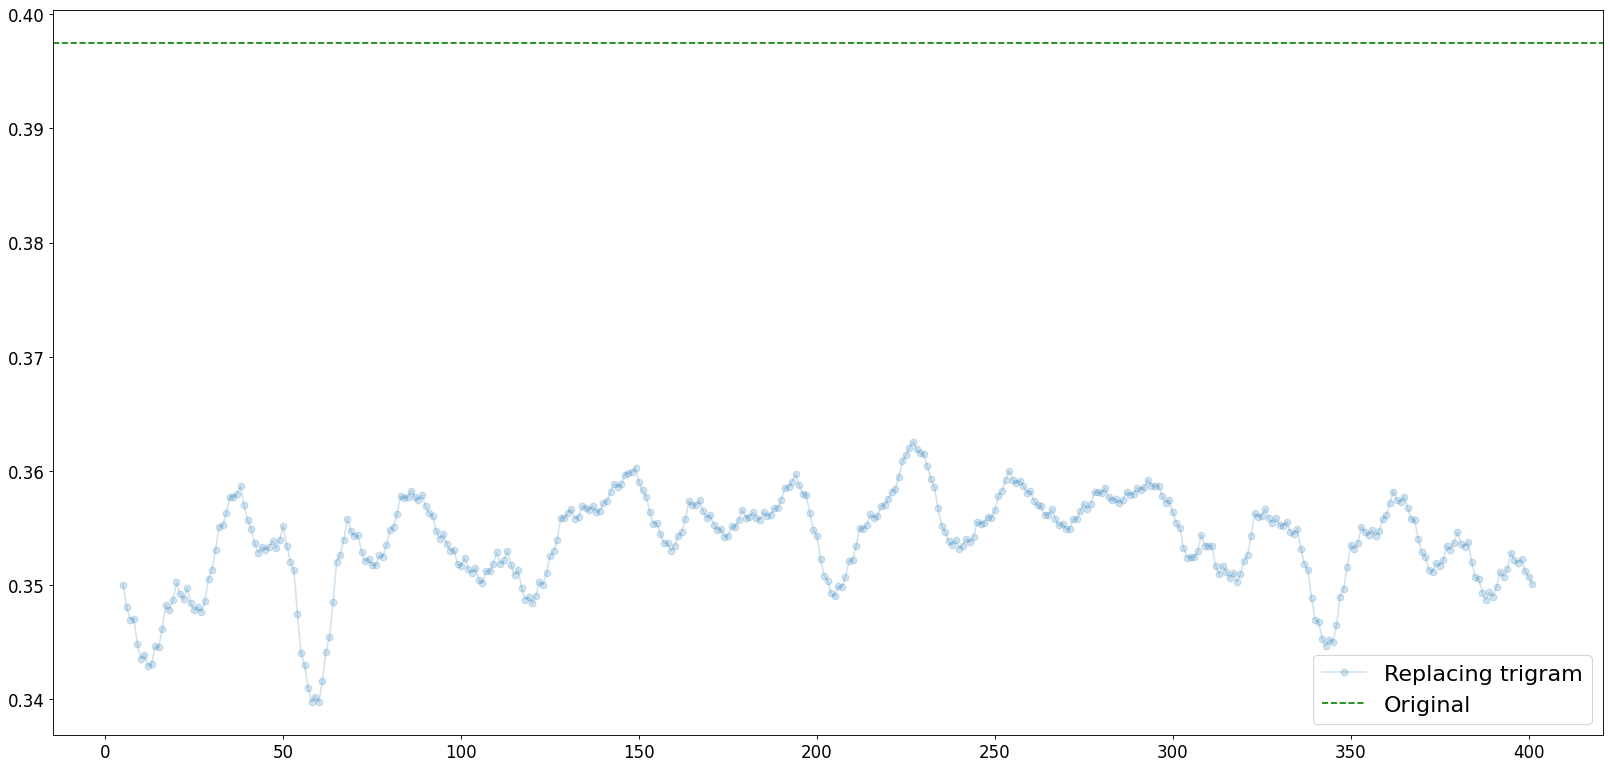

In [54]:
figure(figsize=(25, 12), dpi=80)
plt.plot(range(len(sample_df_5fold_average[0]['replaced_trigram'].tolist())),moving_avg(sample_df_5fold_average[0]['Averaged Predictions'].tolist(), window_size=10), '-o', alpha=0.2, label='Replacing trigram')
plt.axhline(y=top_df['Averaged Predictions'].tolist()[35], color='g', linestyle='--', label='Original')
plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=20)
plt.show()

# Grouping Ligands for TRIM59 based on Active Binding Pockets

In [18]:
top_df_TRIM59 = top_df[top_df['gene'] == 'TRIM59']

In [19]:
top_df_TRIM59

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
0,333533,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.438937,0
3,1362803,GVEAYVLWDAFXET-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.429415,0
7,1186583,BGSZAXLLHYERSY-XQIGCQGXSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.416842,0
8,2628353,RJURFGZVJUQBHK-IIXSONLDSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.416358,0
15,2032043,HTIKWNNIPGXLGM-YLINKJIISA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.405274,0
16,2183843,YXRDKMPIGHSVRX-OOJCLDBCSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.404781,0
17,1341353,HMEYVGGHISAPJR-IAHYZSEUSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.402276,0
18,1950203,METQSPRSQINEEU-WLNGPIDUNA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.401957,0
19,2229383,METQSPRSQINEEU-HXCATZOESA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.401957,0
22,764183,YJDYDFNKCBANTM-QCWCSKBGSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.400471,0


## Pocket 3

In [19]:
class_middle_binders = ['PKVRCIRHQMSYJX-AIFWHQITSA-N','OIJXLIIMXHRJJH-KNLIIKEYSA-N','NYOXRYYXRWJDKP-GYKMGIIDSA-N','LKAJKIOFIWVMDJ-IYRCEVNGSA-N','IVFYLRMMHVYGJH-PVPPCFLZSA-N','DIGFQJFCDPKEPF-OIUSMDOTSA-L']

In [20]:
top_df_TRIM59_middle_binders = top_df_TRIM59[top_df_TRIM59['InChiKey'].isin(class_middle_binders)]

In [17]:
top_df_TRIM59_middle_binders

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
26,76133,DIGFQJFCDPKEPF-OIUSMDOTSA-L,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.399083,0
67,2456423,IVFYLRMMHVYGJH-PVPPCFLZSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.390819,0
75,992543,OIJXLIIMXHRJJH-KNLIIKEYSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.389691,0
85,1225523,NYOXRYYXRWJDKP-GYKMGIIDSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.388854,0
96,2610863,PKVRCIRHQMSYJX-AIFWHQITSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387410,0
97,2151503,LKAJKIOFIWVMDJ-IYRCEVNGSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.387335,0


In [18]:
protein_seq = top_df['target_aa_code'].tolist()[0]

middle_binders_prediction_list = []

for index, row in tqdm(top_df_TRIM59_middle_binders.iterrows()):

    sample_df = pd.DataFrame()

    ligand_inchikey = row['InChiKey']
    ligand_smile = drugs[drugs['InChiKey'] == row['InChiKey']]['SMILE'].tolist()[0]
    InChIKey_list = []
    target_aa_code_list = []
    smile_list = []
    replaced_trigram_list = []

    for j in tqdm(range(0,len(protein_seq)-3)):

        replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

        InChIKey_list.append(ligand_inchikey)
        target_aa_code_list.append(protein_seq_replaced)
        smile_list.append(ligand_smile)
        replaced_trigram_list.append(replaced_trigram)

    sample_df['InChiKey'] = InChIKey_list
    sample_df['SMILE'] = smile_list
    sample_df['target_aa_code'] = target_aa_code_list
    sample_df['replaced_trigram'] = replaced_trigram_list
    
    middle_binders_prediction_list.append(sample_df)

0it [00:00, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [19]:
sample_df_5fold_average_middle_binders = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = middle_binders_prediction_list,
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402


In [20]:
middle_binders_prediction_list = []

for j in range(len(sample_df_5fold_average_middle_binders)):
    middle_binders_prediction_list.append(sample_df_5fold_average_middle_binders[j]['Averaged Predictions'].tolist())

In [21]:
colors_list = ['#543005','#8c510a','#bf812d','#dfc27d','#80cdc1','#35978f','#01665e','#003c30']

In [22]:
name_list = ['Metocurine iodide (-7.8 kcal/mole)', 'Calusterone (-7.3 kcal/mole)', 'Diprenorphine (-6.6 kcal/mole)', 'Cholestenone (-7.1 kcal/mole)', 'Trabectedin (-7.4 kcal/mole)', 'Stanozolol (-7.3 kcal/mole)']

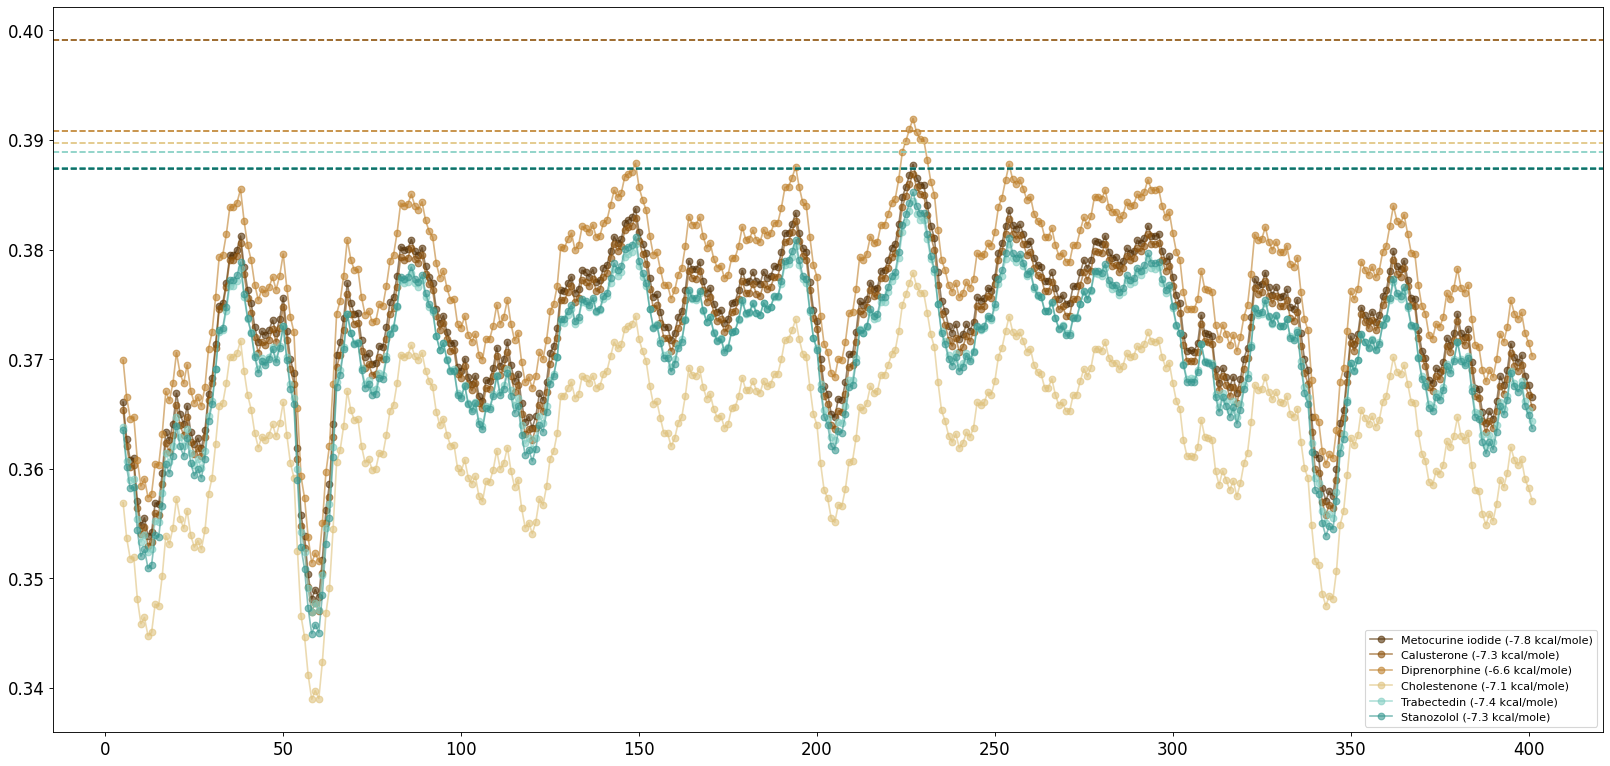

In [24]:
figure(figsize=(25, 12), dpi=80)
for j in range(len(middle_binders_prediction_list)):
    prediction_list = middle_binders_prediction_list[j]
    plt.plot(range(len(prediction_list)),moving_avg(prediction_list, window_size=10), '-o', color = colors_list[j], alpha=0.6, label=name_list[j])

j = 0
for index, row in top_df_TRIM59_middle_binders.iterrows():
    j = j + 1
    plt.axhline(y=row['Averaged Predictions'], color = colors_list[j], linestyle='--')

plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=10)
plt.show()

## Pocket 2

In [21]:
class_front_middle_binders = ['RMRJXGBAOAMLHD-IHFGGWKQSA-N', 'SEALOBQTUQIVGU-QNIJNHAOSA-N', 'OSVMTWJCGUFAOD-KZQROQTASA-N', 'OIJXLIIMXHRJJH-USQHPYHMSA-N', 'ICMWWNHDUZJFDW-DHODBPELSA-N', 'CAHGCLMLTWQZNJ-BQNIITSRSA-N']

In [22]:
name_list = ['Buprenorphine (-6.6 kcal/mole)', 'Dihydroergocornine (-8 kcal/mole)', 'Formestane (-7.2 kcal/mole)', 'CHEMBL24995 (-7.5 kcal/mole)', 'Oxymetholone (-7.3 kcal/mole)', 'Lanosterol (-7.8 kcal/mole)']

In [23]:
top_df_TRIM59_front_middle_binders = top_df_TRIM59[top_df_TRIM59['InChiKey'].isin(class_front_middle_binders)]

In [24]:
protein_seq = top_df['target_aa_code'].tolist()[0]

front_middle_binders_prediction_list = []

for index, row in tqdm(top_df_TRIM59_front_middle_binders.iterrows()):

    sample_df = pd.DataFrame()

    ligand_inchikey = row['InChiKey']
    ligand_smile = drugs[drugs['InChiKey'] == row['InChiKey']]['SMILE'].tolist()[0]
    InChIKey_list = []
    target_aa_code_list = []
    smile_list = []
    replaced_trigram_list = []

    for j in tqdm(range(0,len(protein_seq)-3)):

        replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

        InChIKey_list.append(ligand_inchikey)
        target_aa_code_list.append(protein_seq_replaced)
        smile_list.append(ligand_smile)
        replaced_trigram_list.append(replaced_trigram)

    sample_df['InChiKey'] = InChIKey_list
    sample_df['SMILE'] = smile_list
    sample_df['target_aa_code'] = target_aa_code_list
    sample_df['replaced_trigram'] = replaced_trigram_list
    
    front_middle_binders_prediction_list.append(sample_df)

0it [00:00, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [25]:
sample_df_5fold_average_front_middle_binders = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = front_middle_binders_prediction_list,
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402


In [26]:
front_middle_binders_prediction_list = []

for j in range(len(sample_df_5fold_average_front_middle_binders)):
    front_middle_binders_prediction_list.append(sample_df_5fold_average_front_middle_binders[j]['Averaged Predictions'].tolist())

In [27]:
colors_list = ['#543005','#8c510a','#bf812d','#dfc27d','#80cdc1','#35978f','#01665e','#003c30']

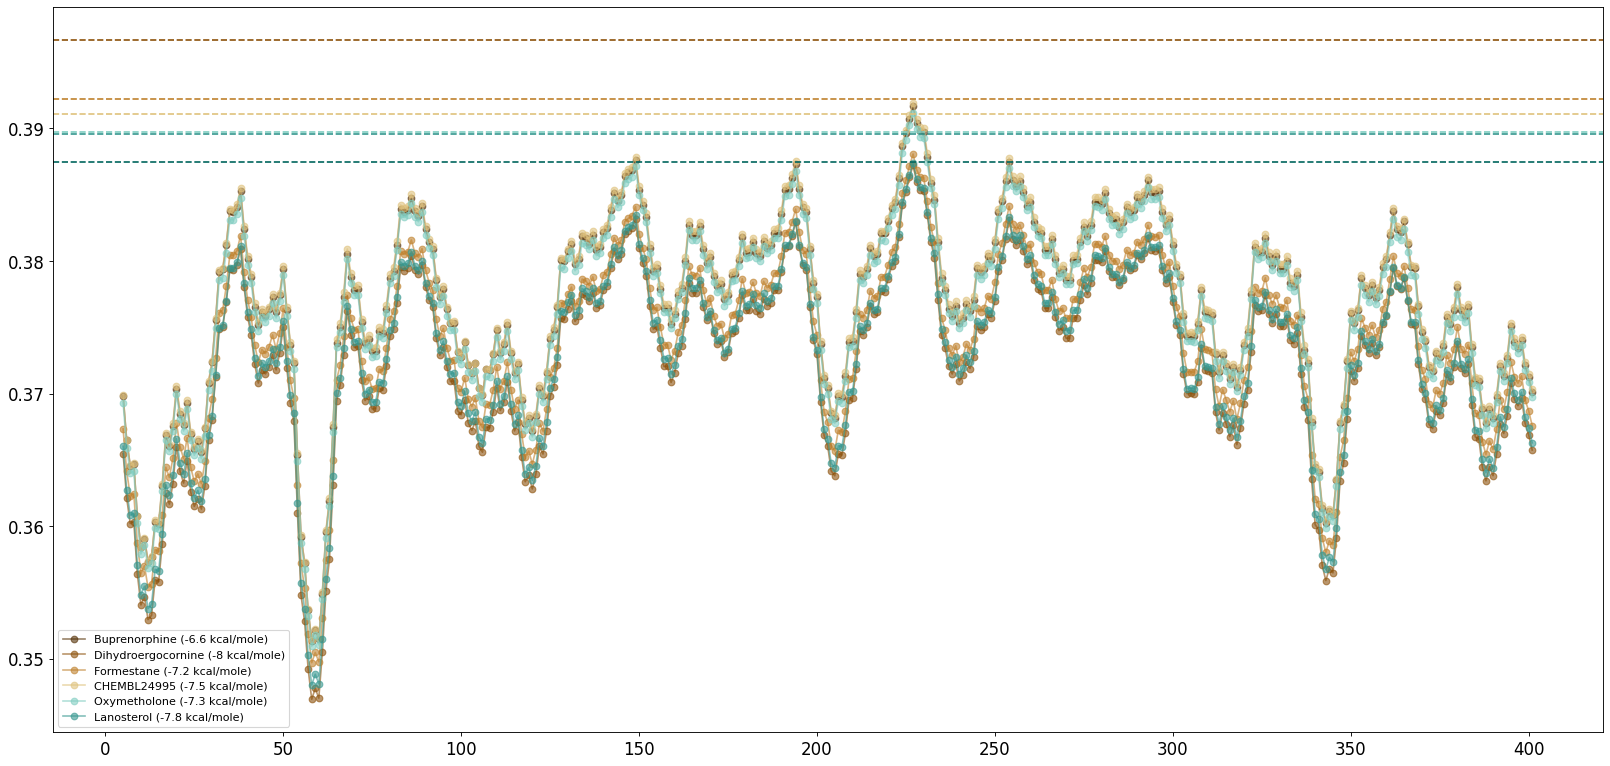

In [30]:
figure(figsize=(25, 12), dpi=80)
for j in range(len(front_middle_binders_prediction_list)):
    prediction_list = front_middle_binders_prediction_list[j]
    plt.plot(range(len(prediction_list)),moving_avg(prediction_list, window_size=10), '-o', color = colors_list[j], alpha=0.6, label=name_list[j])

j = 0
for index, row in top_df_TRIM59_front_middle_binders.iterrows():
    j = j + 1
    plt.axhline(y=row['Averaged Predictions'], color = colors_list[j], linestyle='--')

plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=10)
plt.show()

## Pocket 1

In [12]:
class_front_binders = ['RJURFGZVJUQBHK-IIXSONLDSA-N', 'TXGZJQLMVSIZEI-UQMAOPSPSA-N', 'WPTTVJLTNAWYAO-KPOXMGGZSA-N', 'METQSPRSQINEEU-HXCATZOESA-N', 'HPFVBGJFAYZEBE-ZLQWOROUSA-N', 'BGSZAXLLHYERSY-XQIGCQGXSA-N']

In [13]:
name_list = ['Dactinomycin (-9 kcal/mole)', 'Bardoxolone (-8.7 kcal/mole)', 'Bardoxolone methyl (-8.6 kcal/mole)', 'Drospirenone (-8.5 kcal/mole)', 'Testosterone cypionate (-8.3 kcal/mole)', 'Vecuronium (-8.1 kcal/mole)']

In [17]:
top_df_TRIM59_front_binders = top_df_TRIM59[top_df_TRIM59['InChiKey'].isin(class_front_binders)]

In [18]:
protein_seq = top_df['target_aa_code'].tolist()[0]

front_binders_prediction_list = []

for index, row in tqdm(top_df_TRIM59_front_binders.iterrows()):

    sample_df = pd.DataFrame()

    ligand_inchikey = row['InChiKey']
    ligand_smile = drugs[drugs['InChiKey'] == row['InChiKey']]['SMILE'].tolist()[0]
    InChIKey_list = []
    target_aa_code_list = []
    smile_list = []
    replaced_trigram_list = []

    for j in tqdm(range(0,len(protein_seq)-3)):

        replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

        InChIKey_list.append(ligand_inchikey)
        target_aa_code_list.append(protein_seq_replaced)
        smile_list.append(ligand_smile)
        replaced_trigram_list.append(replaced_trigram)

    sample_df['InChiKey'] = InChIKey_list
    sample_df['SMILE'] = smile_list
    sample_df['target_aa_code'] = target_aa_code_list
    sample_df['replaced_trigram'] = replaced_trigram_list
    
    front_binders_prediction_list.append(sample_df)

0it [00:00, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [19]:
sample_df_5fold_average_front_binders = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = front_binders_prediction_list,
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402


In [20]:
front_binders_prediction_list = []

for j in range(len(sample_df_5fold_average_front_binders)):
    front_binders_prediction_list.append(sample_df_5fold_average_front_binders[j]['Averaged Predictions'].tolist())

In [21]:
colors_list = ['#543005','#8c510a','#bf812d','#dfc27d','#80cdc1','#35978f','#01665e','#003c30']

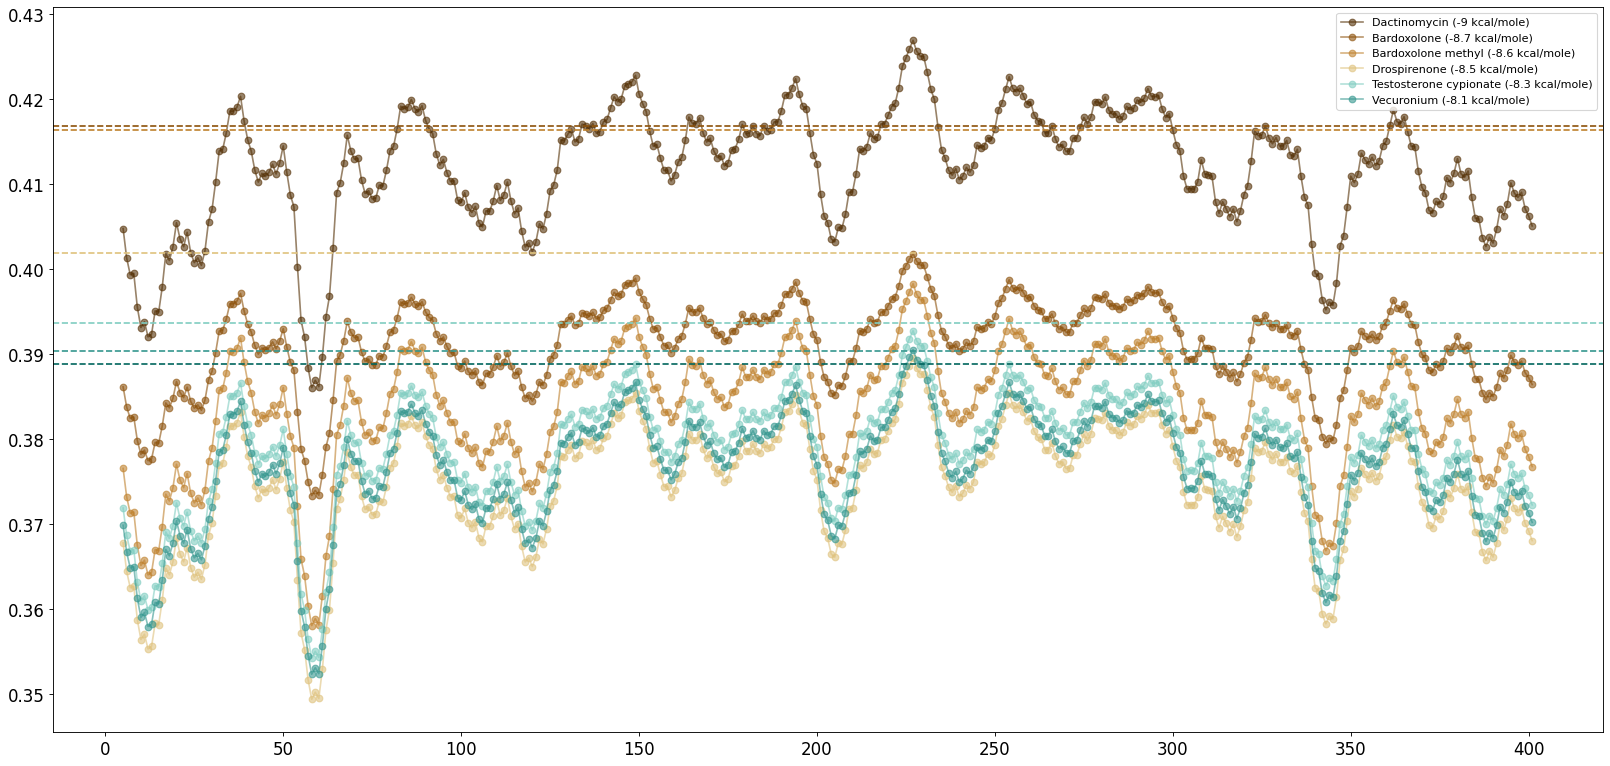

In [23]:
figure(figsize=(25, 12), dpi=80)
for j in range(len(front_binders_prediction_list)):
    prediction_list = front_binders_prediction_list[j]
    plt.plot(range(len(prediction_list)),moving_avg(prediction_list, window_size=10), '-o', color = colors_list[j], alpha=0.6, label=name_list[j])

j = 0
for index, row in top_df_TRIM59_front_binders.iterrows():
    j = j + 1
    plt.axhline(y=row['Averaged Predictions'], color = colors_list[j], linestyle='--')
    
plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.legend(fontsize=10)
plt.show()

## Different types of drugs plotted together

In [29]:
different_class_binders = ['RJURFGZVJUQBHK-IIXSONLDSA-N','RMRJXGBAOAMLHD-IHFGGWKQSA-N','PKVRCIRHQMSYJX-AIFWHQITSA-N']

In [30]:
name_list = ['Dactinomycin (-9 kcal/mole)','Buprenorphine (-6.6 kcal/mole)','Metocurine iodide (-7.8 kcal/mole)']

In [31]:
top_df_TRIM59_different_binders = top_df_TRIM59[top_df_TRIM59['InChiKey'].isin(different_class_binders)]

In [32]:
protein_seq = top_df['target_aa_code'].tolist()[0]

different_binders_prediction_list = []

for index, row in tqdm(top_df_TRIM59_different_binders.iterrows()):

    sample_df = pd.DataFrame()

    ligand_inchikey = row['InChiKey']
    ligand_smile = drugs[drugs['InChiKey'] == row['InChiKey']]['SMILE'].tolist()[0]
    InChIKey_list = []
    target_aa_code_list = []
    smile_list = []
    replaced_trigram_list = []

    for j in tqdm(range(0,len(protein_seq)-3)):

        replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

        InChIKey_list.append(ligand_inchikey)
        target_aa_code_list.append(protein_seq_replaced)
        smile_list.append(ligand_smile)
        replaced_trigram_list.append(replaced_trigram)

    sample_df['InChiKey'] = InChIKey_list
    sample_df['SMILE'] = smile_list
    sample_df['target_aa_code'] = target_aa_code_list
    sample_df['replaced_trigram'] = replaced_trigram_list
    
    different_binders_prediction_list.append(sample_df)

0it [00:00, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [33]:
sample_df_5fold_average_different_binders = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = different_binders_prediction_list,
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402


In [34]:
different_binders_prediction_list = []

for j in range(len(sample_df_5fold_average_different_binders)):
    different_binders_prediction_list.append(sample_df_5fold_average_different_binders[j]['Averaged Predictions'].tolist())

In [35]:
colors_list = ['#543005','#8c510a','#bf812d','#dfc27d','#80cdc1','#35978f','#01665e','#003c30']

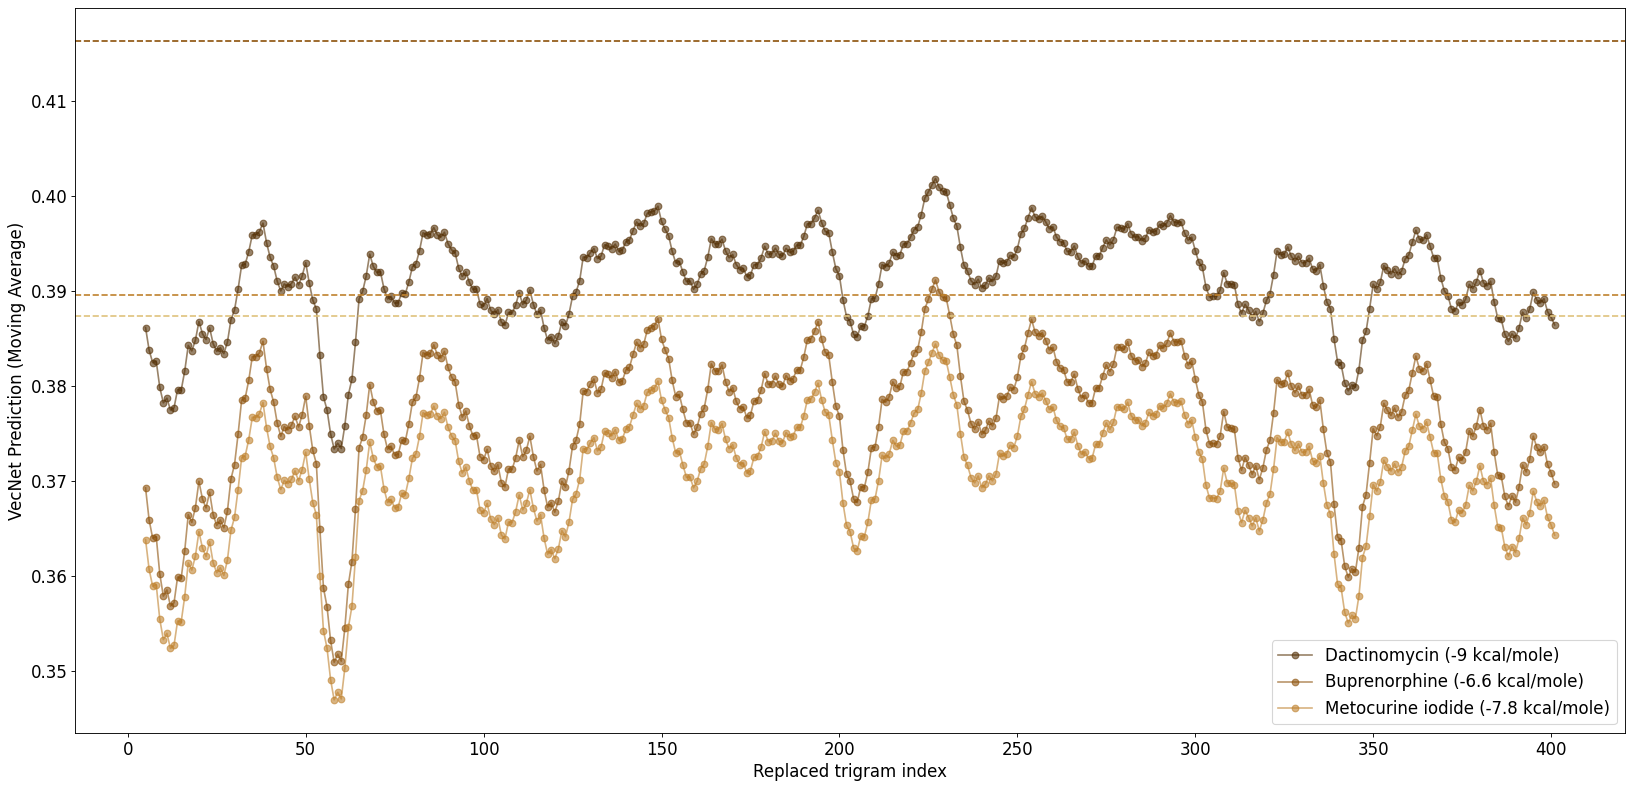

In [37]:
figure(figsize=(25, 12), dpi=80)
for j in range(3): #len(different_binders_prediction_list)):
    prediction_list = different_binders_prediction_list[j]
    plt.plot(range(len(prediction_list)),moving_avg(prediction_list, window_size=10), '-o', color = colors_list[j], alpha=0.6, label=name_list[j])

j = 0
for index, row in top_df_TRIM59_different_binders.iterrows():
    j = j + 1
    plt.axhline(y=row['Averaged Predictions'], color = colors_list[j], linestyle='--')

plt.xticks(rotation = 0,fontsize=15)
plt.yticks(rotation = 0,fontsize=15)
plt.xlabel('Replaced trigram index',fontsize=15)
plt.ylabel('VecNet Prediction (Moving Average)',fontsize=15)
plt.legend(fontsize=15)
plt.show()

# All Ligands Binding to TRIM59 Validated Using Auto-docking

In [20]:
## Compounds used in auto docking and foudn on PubChem

pocket_3_binders = ['PKVRCIRHQMSYJX-AIFWHQITSA-N','OIJXLIIMXHRJJH-KNLIIKEYSA-N','NYOXRYYXRWJDKP-GYKMGIIDSA-N','LKAJKIOFIWVMDJ-IYRCEVNGSA-N','IVFYLRMMHVYGJH-PVPPCFLZSA-N','DIGFQJFCDPKEPF-OIUSMDOTSA-L','BICRTLVBTLFLRD-PTWUADNWSA-N']
pocket_2_binders = ['RMRJXGBAOAMLHD-IHFGGWKQSA-N', 'SEALOBQTUQIVGU-QNIJNHAOSA-N', 'OSVMTWJCGUFAOD-KZQROQTASA-N', 'OIJXLIIMXHRJJH-USQHPYHMSA-N', 'ICMWWNHDUZJFDW-DHODBPELSA-N', 'CAHGCLMLTWQZNJ-BQNIITSRSA-N','JFXBEKISTKFVAB-AJQTZOPKSA-N','YKOPWPOFWMYZJZ-PRIAQAIDSA-N','JUKPWJGBANNWMW-VWBFHTRKSA-N','JVLBPIPGETUEET-WIXLDOGYSA-O','HTIKWNNIPGXLGM-YLINKJIISA-N','DYKFCLLONBREIL-KVUCHLLUSA-N','HMEYVGGHISAPJR-IAHYZSEUSA-N']
pocket_1_binders = ['RJURFGZVJUQBHK-IIXSONLDSA-N', 'TXGZJQLMVSIZEI-UQMAOPSPSA-N', 'WPTTVJLTNAWYAO-KPOXMGGZSA-N', 'METQSPRSQINEEU-HXCATZOESA-N', 'HPFVBGJFAYZEBE-ZLQWOROUSA-N', 'BGSZAXLLHYERSY-XQIGCQGXSA-N', 'MFYSYFVPBJMHGN-ZPOLXVRWSA-N','PMATZTZNYRCHOR-CGLBZJNRSA-N','MPYLDWFDPHRTEG-PAAYLBSLSA-N','MIJYXULNPSFWEK-GTOFXWBISA-N','VUCSBBBCFXBFFY-IBGZPJMESA-N','LXMSZDCAJNLERA-ZHYRCANASA-N','OWWLUIWOFHMHOQ-XGHATYIMSA-N','YJDYDFNKCBANTM-QCWCSKBGSA-N']

In [21]:
all_TRIM59_binders = pocket_1_binders + pocket_2_binders + pocket_3_binders # top_df_TRIM59['InChiKey'].tolist()

In [25]:
protein_seq = top_df['target_aa_code'].tolist()[0]

all_binders_prediction_list = []

#for index, row in tqdm(top_df_TRIM59.iterrows()):
for inchikey in tqdm(all_TRIM59_binders):

    sample_df = pd.DataFrame()

    ligand_inchikey = inchikey # row['InChiKey']
    ligand_smile = drugs[drugs['InChiKey'] == inchikey]['SMILE'].tolist()[0] # drugs[drugs['InChiKey'] == row['InChiKey']]['SMILE'].tolist()[0]
    InChIKey_list = []
    target_aa_code_list = []
    smile_list = []
    replaced_trigram_list = []

    for j in tqdm(range(0,len(protein_seq)-3)):

        replaced_trigram, protein_seq_replaced = replacer(protein_seq, 'xxx', index=j, nofail=False)

        InChIKey_list.append(ligand_inchikey)
        target_aa_code_list.append(protein_seq_replaced)
        smile_list.append(ligand_smile)
        replaced_trigram_list.append(replaced_trigram)

    sample_df['InChiKey'] = InChIKey_list
    sample_df['SMILE'] = smile_list
    sample_df['target_aa_code'] = target_aa_code_list
    sample_df['replaced_trigram'] = replaced_trigram_list
    
    all_binders_prediction_list.append(sample_df)

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

  0%|          | 0/402 [00:00<?, ?it/s]

In [26]:
sample_df_5fold_all_binders = vecnet_object.get_fold_averaged_prediction_results( model_name = None,
                                                                                     version_number = None,
                                                                                     model_paths = [],
                                                                                     optimal_validation_model = None,
                                                                                     test_sets = all_binders_prediction_list,
                                                                                     get_drug_embed = True,
                                                                                     get_target_embed = True,
                                                                                     drug_filter_list = [],
                                                                                     target_filter_list = [],
                                                                                     return_dataframes = True )

Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_0/vecnet_ds2_5_fold_unseen_nodes_v00_run0_07-13_15h58_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_1/vecnet_ds2_5_fold_unseen_nodes_v00_run1_07-13_16h01_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_2/vecnet_ds2_5_fold_unseen_nodes_v00_run2_07-13_16h03_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_3/vecnet_ds2_5_fold_unseen_nodes_v00_run3_07-13_16h07_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
Testing on model :  /data/sars-busters-consolidated/GitData/vecnet-final/Run_4/vecnet_ds2_5_fold_unseen_nodes_v00_run4_07-13_16h09_epoch_19_idx_0.model
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
filtered_nodes_test :  (402, 4)
Drugs :  1
Targets :  402


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

X0, X1 :  (402, 100) (402, 300)
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
unseen_targets_pred :  (402,)
list :  402
un

In [27]:
for i in tqdm(range(34)):
    sample_df_5fold_all_binders[i].to_csv('/data/sars-busters-consolidated/GitData/auto_docked_trigram_study_' + str(i) + '.csv')

  0%|          | 0/34 [00:00<?, ?it/s]

# Analysis of Binding Affinities

In [26]:
print('Number of ligands binding in pocket 1:', len(pocket_1_binders))
print('Number of ligands binding in pocket 2:', len(pocket_2_binders))
print('Number of ligands binding in pocket 3:', len(pocket_3_binders))

Number of ligands binding in pocket 1: 14
Number of ligands binding in pocket 2: 13
Number of ligands binding in pocket 3: 7


In [28]:
TRIM59_aa_code = top_df_TRIM59['target_aa_code'].tolist()[0]

In [29]:
TRIM59_aa_code

'QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNFYIWRPLRIPLKCPNCRSITEIAPTGIESLPVNFALRAIIEKYQQEDHPDIVTCPEHYRQPLNVYCLLDKKLVCGHCLTIGQHHGHPIDDLQSAYLKEKDTPQKLLEQLTDTHWTDLTHLIEKLKEQKSHSEKMIQGDKEAVLQYFKELNDTLEQKKKSFLTALCDVGNLINQEYTPQIERMKEIREQQLELMALTISLQEESPLKFLEKVDDVRQHVQILKQRPLPEVQPVEIYPRVSKILKEEWSRTEIGQIKNVLIPKMKISPKRMSCSWPGKDEKEVEFLKILNIVVVTLISVILMSILFFNQHIITFLSEITLIWFSEASLSVYQSLSNSLHKVKNILCHIFYLLKEFVWKIVSH'

In [29]:
len(TRIM59_aa_code)

405

In [98]:
pocket_3_binding_affinity = [-7.8,-7.3,-6.6,-7.1,-7.4,-7.3,-5.9]
pocket_2_binding_affinity = [-6.6,-8,-7.2,-7.5,-7.3,-7.8,-8.1,-7.6,-7.8,-6.3,-6.8,-6.4,-7.8,]
pocket_1_binding_affinity = [-9,-8.7,-8.6,-8.5,-8.3,-8.1,-7.1,-6.8,-7,-8,-7.5,-7.1,-7.6,-6.5]

In [ ]:
original_pred_list = top_df_TRIM59['Averaged Predictions'].tolist()
delta_list_list = []

for j in range(len(sample_df_5fold_all_binders)):
    delta_list = [x - original_pred_list[j] for x in sample_df_5fold_all_binders[j]['Averaged Predictions'].tolist()]
    delta_list_list.append(delta_list)

In [97]:
top_df_TRIM59

,Unnamed: 0,InChiKey,target_aa_code,gene,Averaged Predictions,is_viral
0,333533,OWWLUIWOFHMHOQ-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.438937,0
3,1362803,GVEAYVLWDAFXET-XGHATYIMSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.429415,0
7,1186583,BGSZAXLLHYERSY-XQIGCQGXSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.416842,0
8,2628353,RJURFGZVJUQBHK-IIXSONLDSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.416358,0
15,2032043,HTIKWNNIPGXLGM-YLINKJIISA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.405274,0
16,2183843,YXRDKMPIGHSVRX-OOJCLDBCSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.404781,0
17,1341353,HMEYVGGHISAPJR-IAHYZSEUSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.402276,0
18,1950203,METQSPRSQINEEU-WLNGPIDUNA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.401957,0
19,2229383,METQSPRSQINEEU-HXCATZOESA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.401957,0
22,764183,YJDYDFNKCBANTM-QCWCSKBGSA-N,QEMHNFEEELTCPICYSIFEDPRVLPCSHTFCRNCLENILQASGNF...,TRIM59,0.400471,0


/miniconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/miniconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



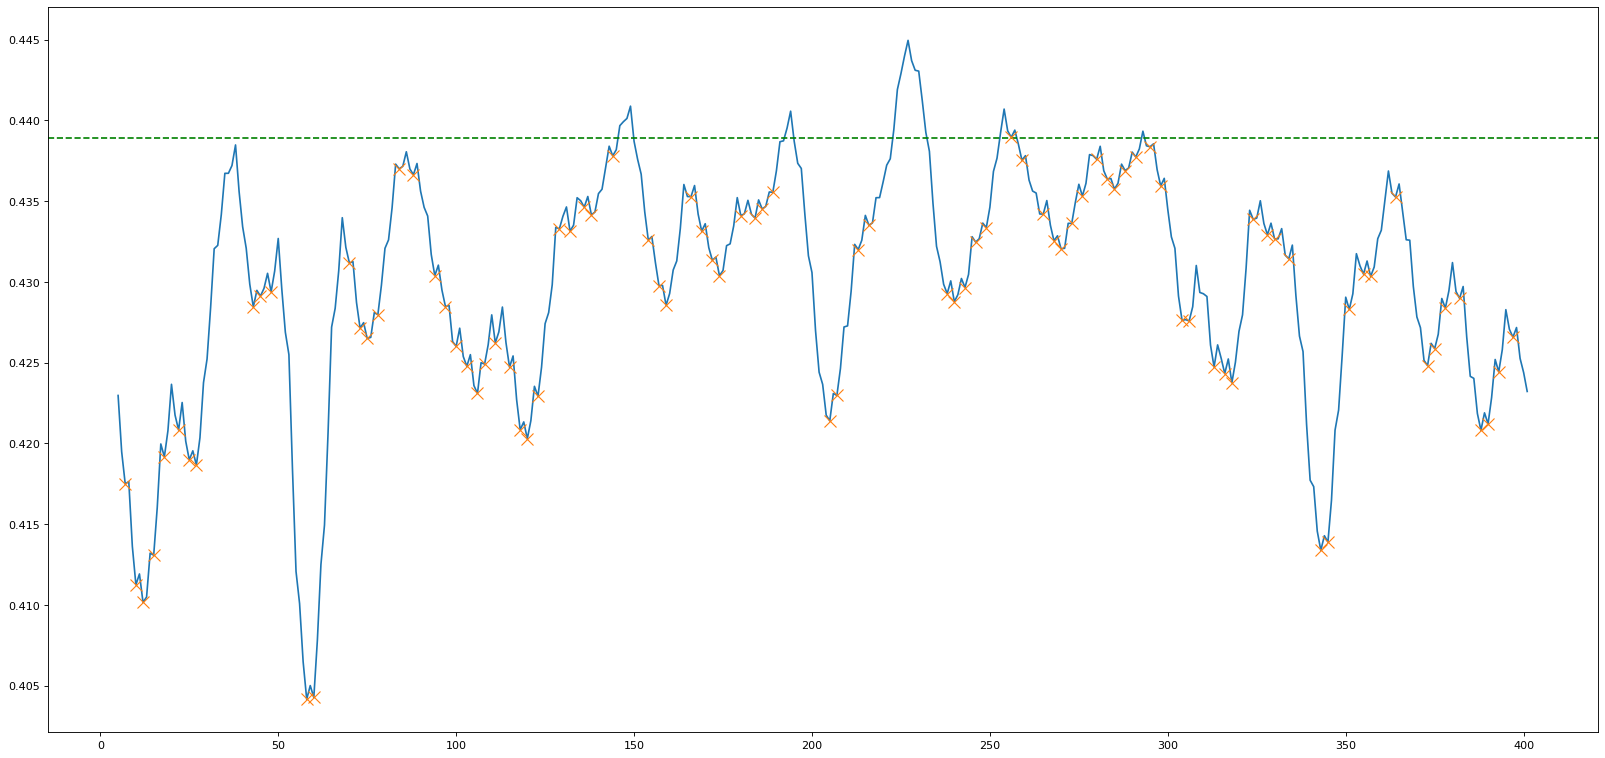

In [114]:
figure(figsize=(25, 12), dpi=80)
x = moving_avg(sample_df_5fold_all_binders[0]['Averaged Predictions'].tolist(), window_size=10)
peaks, _ = find_peaks([-j for j in x])
plt.plot(x)
plt.axhline(y=top_df_TRIM59['Averaged Predictions'].tolist()[0], color='g', linestyle='--')
plt.plot(peaks, [x[j] for j in peaks], "x", markersize=10)

In [115]:
peaks

array([  7,  10,  12,  15,  18,  22,  25,  27,  43,  45,  48,  58,  60,
        70,  73,  75,  78,  84,  88,  94,  97, 100, 103, 106, 108, 111,
       115, 118, 120, 123, 129, 132, 136, 138, 144, 154, 157, 159, 166,
       169, 172, 174, 180, 184, 186, 189, 205, 207, 213, 216, 238, 240,
       243, 246, 249, 256, 259, 265, 268, 270, 273, 276, 280, 283, 285,
       288, 291, 295, 298, 304, 306, 313, 316, 318, 324, 328, 330, 334,
       343, 345, 351, 355, 357, 364, 373, 375, 378, 382, 388, 390, 393,
       397])

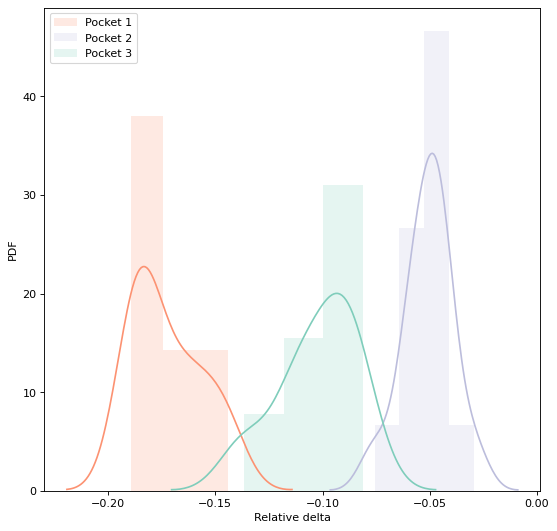

-0.17245322572893654
-0.05081461272757799
-0.10247088565470985


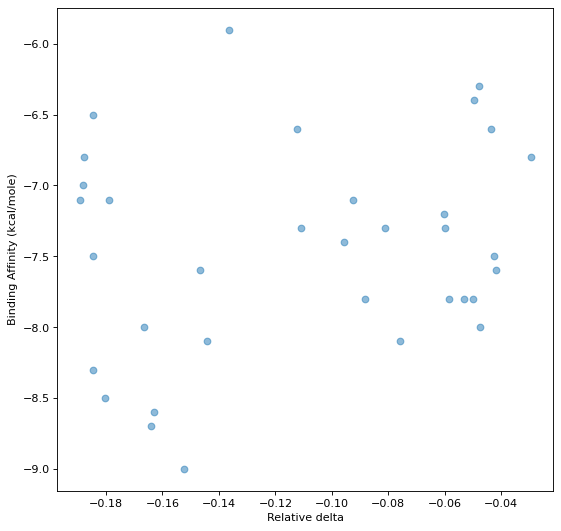

Relative delta and binding affinity:  SpearmanrResult(correlation=0.12781285911877127, pvalue=0.47130524102123006)


In [116]:
## Deepest valleys

original_pred_list = top_df_TRIM59['Averaged Predictions'].tolist()

valleys = [58] 

delta_pocket_1 = []

for inchikey in pocket_1_binders:
    index_val = top_df_TRIM59['InChiKey'].tolist().index(inchikey)
    each_valley_delta = []
    for valley in valleys:
        each_valley_delta.append((sample_df_5fold_all_binders[index_val]['Averaged Predictions'].tolist()[valley] - original_pred_list[index_val])/original_pred_list[index_val])
    delta_pocket_1.append(np.mean(each_valley_delta))

valleys = [120] 
    
delta_pocket_2 = []

for inchikey in pocket_2_binders:
    index_val = top_df_TRIM59['InChiKey'].tolist().index(inchikey)
    each_valley_delta = []
    for valley in valleys:
        each_valley_delta.append((sample_df_5fold_all_binders[index_val]['Averaged Predictions'].tolist()[valley] - original_pred_list[index_val])/original_pred_list[index_val])
    delta_pocket_2.append(np.mean(each_valley_delta))
    
valleys = [205]
    
delta_pocket_3 = []

for inchikey in pocket_3_binders:
    index_val = top_df_TRIM59['InChiKey'].tolist().index(inchikey)
    each_valley_delta = []
    for valley in valleys:
        each_valley_delta.append((sample_df_5fold_all_binders[index_val]['Averaged Predictions'].tolist()[valley] - original_pred_list[index_val])/original_pred_list[index_val])
    delta_pocket_3.append(np.mean(each_valley_delta))
    
figure(figsize=(8, 8), dpi=80)
sns_plot_1 = sns.distplot(delta_pocket_1, color='#fc9272',kde=True, label='Pocket 1', hist=True, hist_kws=dict(alpha=0.2))
sns_plot_2 = sns.distplot(delta_pocket_2, color='#bcbddc', kde=True, label='Pocket 2', hist=True,  hist_kws=dict(alpha=0.2))
sns_plot_3 = sns.distplot(delta_pocket_3, color='#7fcdbb', kde=True, label='Pocket 3', hist=True,  hist_kws=dict(alpha=0.2))
plt.xlabel('Relative delta')
plt.ylabel('PDF')
plt.legend()
plt.show()

print(np.mean(delta_pocket_1))
print(np.mean(delta_pocket_2))
print(np.mean(delta_pocket_3))
    
figure(figsize=(8, 8), dpi=80)
plt.scatter(delta_pocket_1+delta_pocket_2+delta_pocket_3,pocket_1_binding_affinity+pocket_2_binding_affinity+pocket_3_binding_affinity, alpha=0.5)
plt.xlabel('Relative delta')
plt.ylabel('Binding Affinity (kcal/mole)')
plt.show()

print('Relative delta and binding affinity: ', stats.spearmanr(delta_pocket_1+delta_pocket_2+delta_pocket_3,pocket_1_binding_affinity+pocket_2_binding_affinity+pocket_3_binding_affinity))

# Clustermap

In [15]:
sample_df_5fold_all_binders = []

for i in tqdm(range(44)):
    load_df = pd.read_csv('/data/sars-busters-consolidated/GitData/auto_docked_trigram_study_' + str(i) + '.csv')
    sample_df_5fold_all_binders.append(load_df)

  0%|          | 0/44 [00:00<?, ?it/s]

## Using Tanimoto Similarity

In [44]:
binding_ligands = drugs[drugs['InChiKey'].isin(pocket_1_binders+pocket_2_binders+pocket_3_binders)]
binding_ligands_SMILEs = []

for inchikey in tqdm(pocket_1_binders+pocket_2_binders+pocket_3_binders):
    binding_ligands_SMILEs.append(binding_ligands[binding_ligands['InChiKey']==inchikey]['SMILE'].tolist()[0])

  0%|          | 0/34 [00:00<?, ?it/s]

In [31]:
def tanimoto_calc(smi1, smi2):
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 3, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 3, nBits=2048)
    s = round(DataStructs.TanimotoSimilarity(fp1,fp2),3)
    return s

In [46]:
chem_count = len(binding_ligands_SMILEs)
tanimoto_matrix = np.zeros((chem_count,chem_count))

for i in tqdm(range(chem_count)):
    for j in range(chem_count):
        tanimoto_matrix[i,j] = tanimoto_calc(binding_ligands_SMILEs[i], binding_ligands_SMILEs[j])

  0%|          | 0/34 [00:00<?, ?it/s]

In [32]:
pocket_1_binders_names = []
for inchikey in pocket_1_binders:
    try:
        c = pcp.get_compounds(inchikey,'inchikey')
        pocket_1_binders_names.append(c[0].synonyms[0].title())
    except:
        pocket_1_binders_names.append(inchikey)
    
pocket_2_binders_names = []
for inchikey in pocket_2_binders:
    try:
        c = pcp.get_compounds(inchikey,'inchikey')
        pocket_2_binders_names.append(c[0].synonyms[0].title())
    except:
        pocket_2_binders_names.append(inchikey)
    
pocket_3_binders_names = []
for inchikey in pocket_3_binders:
    try:
        c = pcp.get_compounds(inchikey,'inchikey')
        pocket_3_binders_names.append(c[0].synonyms[0].title())
    except:
        pocket_3_binders_names.append(inchikey)

In [33]:
pocket_1_binders_names[10] = 'CHEMBL1235837'

In [34]:
pocket_2_binders_names[11] = 'Minocycline'
pocket_2_binders_names[12] = 'ROLITETRACYCLINE'.title()

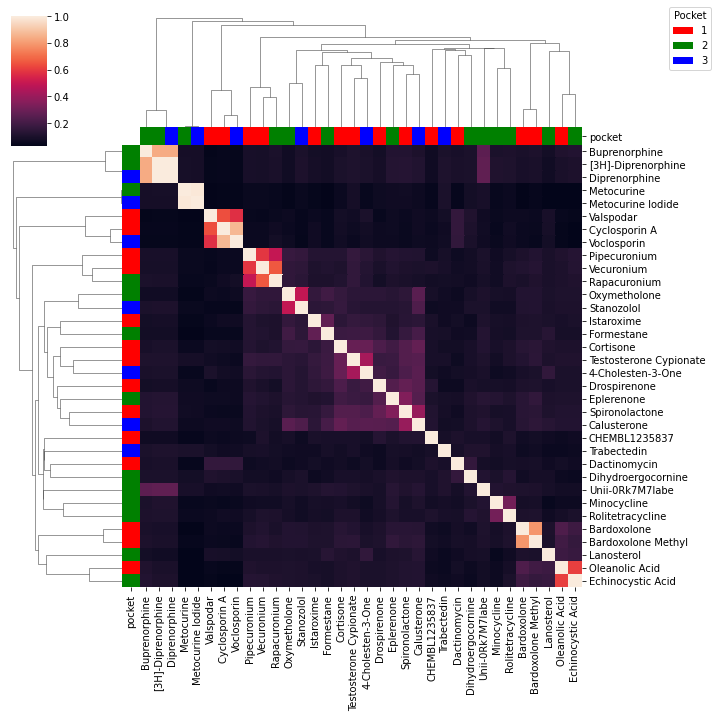

In [47]:
tanimoto_df = pd.DataFrame(tanimoto_matrix)
tanimoto_df.index = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
tanimoto_df.columns = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
tanimoto_df['pocket'] = [1] * len(pocket_1_binders) + [2] * len(pocket_2_binders) + [3] * len(pocket_3_binders)


Pocket = tanimoto_df.pop("pocket")
lut = dict(zip(Pocket.unique(), "rgb"))
row_colors = Pocket.map(lut)
g = sns.clustermap(tanimoto_df, row_colors=row_colors, col_colors=row_colors) #, cmap="vlag")

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Pocket',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

## Using original trajectories

### Spearman Correlation

In [56]:
chem_count = len(binding_ligands_SMILEs)
trajecotry_similarity_matrix = np.zeros((chem_count,chem_count))

for i in tqdm(range(chem_count)):
    for j in range(chem_count):
        trajectory_1 = sample_df_5fold_all_binders[i]['Averaged Predictions'].tolist()
        trajectory_2 = sample_df_5fold_all_binders[j]['Averaged Predictions'].tolist()
        trajecotry_similarity_matrix[i,j] = stats.spearmanr(trajectory_1, trajectory_2)[0] 

  0%|          | 0/34 [00:00<?, ?it/s]

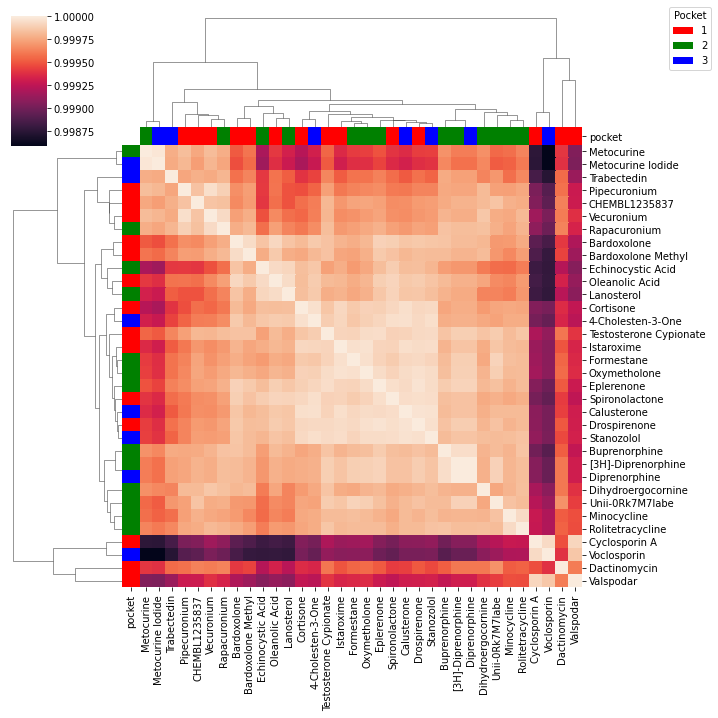

In [57]:
trajecotry_similarity_df = pd.DataFrame(trajecotry_similarity_matrix)
trajecotry_similarity_df.index = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
trajecotry_similarity_df.columns = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
trajecotry_similarity_df['pocket'] = [1] * len(pocket_1_binders) + [2] * len(pocket_2_binders) + [3] * len(pocket_3_binders)

Pocket = trajecotry_similarity_df.pop("pocket")
lut = dict(zip(Pocket.unique(), "rgb"))
row_colors = Pocket.map(lut)
g = sns.clustermap(trajecotry_similarity_df, row_colors=row_colors, col_colors=row_colors) #, cmap="vlag")

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Pocket',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')

### Pearson's Correlation

In [50]:
chem_count = len(binding_ligands_SMILEs)
trajecotry_similarity_matrix = np.zeros((chem_count,chem_count))

for i in tqdm(range(chem_count)):
    for j in range(chem_count):
        trajectory_1 = sample_df_5fold_all_binders[i]['Averaged Predictions'].tolist()
        trajectory_2 = sample_df_5fold_all_binders[j]['Averaged Predictions'].tolist()
        trajecotry_similarity_matrix[i,j] = stats.pearsonr(trajectory_1, trajectory_2)[0]

  0%|          | 0/34 [00:00<?, ?it/s]

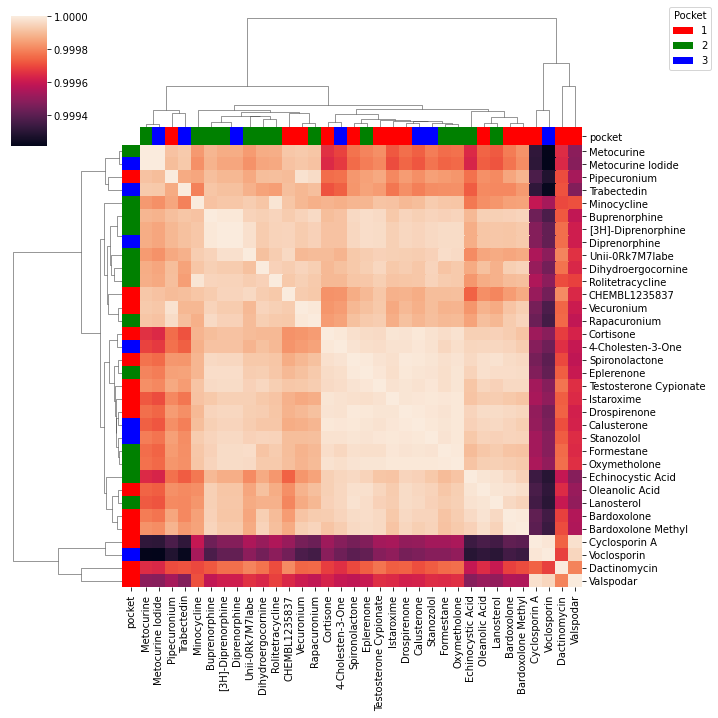

In [51]:
trajecotry_similarity_df = pd.DataFrame(trajecotry_similarity_matrix)
trajecotry_similarity_df.index = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
trajecotry_similarity_df.columns = pocket_1_binders_names + pocket_2_binders_names + pocket_3_binders_names
trajecotry_similarity_df['pocket'] = [1] * len(pocket_1_binders) + [2] * len(pocket_2_binders) + [3] * len(pocket_3_binders)

Pocket = trajecotry_similarity_df.pop("pocket")
lut = dict(zip(Pocket.unique(), "rgb"))
row_colors = Pocket.map(lut)
g = sns.clustermap(trajecotry_similarity_df, row_colors=row_colors, col_colors=row_colors) #, cmap="vlag")

handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Pocket',
           bbox_to_anchor=(1, 1), bbox_transform=plt.gcf().transFigure, loc='upper right')